# Unit 4 Capstone 
Author: Bryan Corder <br>
Mentor: Hoa Tran <br>

People who study wine, know there are certain aromas associated with varieties such as black currants with Cabernet Sauvignon. The average consumer is right to be skeptical about wine descriptions when they range from "freshly cut garden hose" to "petrol" when it would be a health violation if any of those were actually put into wine.

However, there is science behind these terms. Pyrazines, which are found in bell peppers and give peppers their aroma, are found in both Cabernet Franc and its offspring (together with Sauvignon Blanc) variety, Cabernet Sauvignon giving both a touch of a "bell pepper" like vegetal quality. Similarly, the same kind of compounds are responsible for aromas of red fruits like strawberries or cherries or stone fruits like peaches or nectarines. Some come from the grape varieties like the above mentioned pyrazines and some aromas come from the wine making process, such as cedar or vanilla from the oak aging process.

Wine descriptions offer information to the consumer about the grape used and the process taken to turn the grapes into the beverage the consumer is imbibing.

This project looks into whether it is possible to create a model to discern through wine descriptions what kind of grape is used to produce the wine. This may seem like a trivial task, but it was not until the mid 1990s until wine consumers found out that the unique expression of Merlot they were drinking from Chile was in fact another Bordeaux variety named Carmenere. Mexicans in Baja California claim all of their grapes are Nebbiollo even though when wine grapes from Piedmont, Italy were brought to Mexico, the tags became illegible with the moisture and it was only assumed that those vines were Nebbiollo. In all likelihood, what we call a Mexican Nebbiollo is actually a blend of Piedmont grapes such as Nebbiollo, Barbera, and Dolcetto. (Source: Karen MacNeil, __Wine Bible__)

After a model is created, this project will use the data to see if any other insights can be gained about grape varieties through clustering.

In [95]:
# Import libraries 
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import unicodedata
from datetime import datetime

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import re


from collections import Counter
%matplotlib inline

## Data
The data comes from Kaggle: https://www.kaggle.com/sierram/cosine-similarity-wine-descriptions/data
The data includes the wine name, source, decription, price, wine producer, and author of the description. Since this study is trying to use the data to name grape varieties, only the description and variety are used.

In [96]:
raw_data = pd.read_csv('winemag-data-130k-v2.csv')
raw_data.head(10)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [97]:
# All we'll need are the country, description and variety. There is one data point without a variety, so let's drop it.
wine_data = raw_data[['country', 'description', 'variety']].dropna()

# The word description will come up in our data, so we need to change the name of the column for clarity.
wine_data = wine_data.rename(columns = {'description': 'description_text'})

# Make all of the varieties lower case so that Pinot Noir and pinot noir are recognized as the same
wine_data['variety'] = wine_data['variety'].str.lower()
wine_data['country'] = wine_data['country'].str.lower()

wine_data.head(10)

,country,description_text,variety
0,italy,"Aromas include tropical fruit, broom, brimston...",white blend
1,portugal,"This is ripe and fruity, a wine that is smooth...",portuguese red
2,us,"Tart and snappy, the flavors of lime flesh and...",pinot gris
3,us,"Pineapple rind, lemon pith and orange blossom ...",riesling
4,us,"Much like the regular bottling from 2012, this...",pinot noir
5,spain,Blackberry and raspberry aromas show a typical...,tempranillo-merlot
6,italy,"Here's a bright, informal red that opens with ...",frappato
7,france,This dry and restrained wine offers spice in p...,gewürztraminer
8,germany,Savory dried thyme notes accent sunnier flavor...,gewürztraminer
9,france,This has great depth of flavor with its fresh ...,pinot gris


There are umlauts and accents, so let's clean that up so the computer recognizes them as the same terms.

In [98]:
# Get rid of the special characters like the umlaut on the u in gewurztraminer
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

wine_data['variety'] = wine_data['variety'].apply(remove_accents)
wine_data['description_text'] = wine_data['description_text'].apply(remove_accents)
   
wine_data.head(10)

,country,description_text,variety
0,italy,"Aromas include tropical fruit, broom, brimston...",white blend
1,portugal,"This is ripe and fruity, a wine that is smooth...",portuguese red
2,us,"Tart and snappy, the flavors of lime flesh and...",pinot gris
3,us,"Pineapple rind, lemon pith and orange blossom ...",riesling
4,us,"Much like the regular bottling from 2012, this...",pinot noir
5,spain,Blackberry and raspberry aromas show a typical...,tempranillo-merlot
6,italy,"Here's a bright, informal red that opens with ...",frappato
7,france,This dry and restrained wine offers spice in p...,gewurztraminer
8,germany,Savory dried thyme notes accent sunnier flavor...,gewurztraminer
9,france,This has great depth of flavor with its fresh ...,pinot gris


The data has a large variety of grapes, but it also has some items that will not be helpful in building a model to identify grape varieties such as "blends" and "roses" which could be made from anything. It also has words in different languages based on where they are produced, so it would be helpful to put the varieties together even though one could argue that a German Spatburgunder does taste different from a red Burgundy even though they are the same variety.

Also, several varieties have relatively few occurances. Paring down the data set will improve the performance for the widely grown grapes without much loss.

In [99]:
print('The original data set contains this many rows: {}'.format(len(wine_data)))
# Replace german names with English names for wines
wine_data['variety'] = wine_data['variety'].replace(['weissburgunder'], 'chardonnay')
wine_data['variety'] = wine_data['variety'].replace(['spatburgunder'], 'pinot noir')
wine_data['variety'] = wine_data['variety'].replace(['grauburgunder'], 'pinot gris')

# Replace the Spanish garnacha with the french grenache 
wine_data['variety'] = wine_data['variety'].replace(['garnacha'], 'grenache')

# Replace the Italian pinot nero with the french pinot noir
wine_data['variety'] = wine_data['variety'].replace(['pinot nero'], 'pinot noir')

# Replace the Portugues alvarinho with the spanish albarino
wine_data['variety'] = wine_data['variety'].replace(['alvarinho'], 'albarino')


# Let's get rid of generic blends
print('There are this many varieties that contain the word blend or "red"')
print(len(wine_data[wine_data.variety.str.contains('blend') == True]) + 
      len(wine_data[wine_data.variety.str.contains('red') == True]))
wine_data = wine_data[wine_data.variety.str.contains('blend') == False]
wine_data = wine_data[wine_data.variety.str.contains('red') == False]

# Drop instances of rose because those can be made from a mulititude of varieties
print('There are this many roses in the data set')
print(len(wine_data[wine_data.variety.str.contains('rose') == True]))
wine_data = wine_data[wine_data.variety.str.contains('rose') == False]


# See how many varieties have a relatively insignificant number of instances and remove them
# This should improve the performance of our model by decreasing the number of possible outcomes without losing utility
print('There are this many wines in the rarer varieties')
print(sum(wine_data['variety'].value_counts()[wine_data['variety'].value_counts()<100]))

variety_counts = wine_data['variety'].value_counts().rename('variety_counts')

wine_data = wine_data.merge(variety_counts.to_frame(),
                                left_on='variety', right_index=True)

wine_data = wine_data[wine_data['variety_counts'] > 100]
wine_data = wine_data.drop(['variety_counts'], axis=1)

print('After cleaning, we now have this many rows of data: {}'.format(len(wine_data)))

The original data set contains this many rows: 129907
There are this many varieties that contain the word blend or "red"
45623
There are this many roses in the data set
3817
There are this many wines in the rarer varieties
6977
After cleaning, we now have this many rows of data: 90736


In [100]:
# Let's take a look at the new data set
wine_data.head(10)

,country,description_text,variety
2,us,"Tart and snappy, the flavors of lime flesh and...",pinot gris
9,france,This has great depth of flavor with its fresh ...,pinot gris
91,us,This wine has a touch of perceptible sweetness...,pinot gris
100,us,"Fresh apple, lemon and pear flavors are accent...",pinot gris
139,france,"Beautiful deep gold color. Intense, concentrat...",pinot gris
143,france,"Rich gold in color. Broad, layered aromas of v...",pinot gris
340,france,"The nose is muted, despite the slight spritz o...",pinot gris
639,france,There are mere hints of beeswax and marzipan o...,pinot gris
641,us,"Completely stainless-fermented and aged, this ...",pinot gris
858,us,Fresh cut pear fruit flavors carry this wine. ...,pinot gris


In [101]:
# Make sure it is not containing Null values
null_count = wine_data.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

Now, let's look at the counts of varieties in the data set.

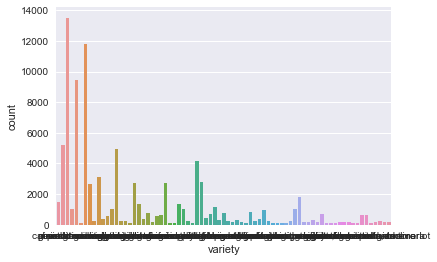

In [102]:
sns.countplot(x='variety', data=wine_data)
plt.show()

Pinot Noir and Chardonnay are especially high. Let's resample them to bring them a tad bit closer to the other varieties.

In [103]:
# First we need to find out what varieties are the popular ones by putting on variety counts
variety_counts = wine_data['variety'].value_counts().rename('variety_counts')

# Attach the counts to the dataframe
wine_data = wine_data.merge(variety_counts.to_frame(),
                                left_on='variety', right_index=True)

# Define what a popular variety is and then get rid of the variety counts
popular_varieties = wine_data[wine_data['variety_counts'] > 7000]
wine_data = wine_data.drop(['variety_counts'], axis=1)

# Set those varieties as a list
popular_varieties = set(popular_varieties['variety'])

In [104]:
# Balance the samples by under sampling
columns_list = list(wine_data.columns.values)
test_df = pd.DataFrame(columns=columns_list)

for x in popular_varieties:
    # Create a local df for the resampling
    temp_df = pd.DataFrame(columns=columns_list)
    
    # Break up the data between the big ones and rest
    temp_df = wine_data[wine_data['variety'] == x]
    
    temp_df = resample(temp_df, n_samples=6000)
    test_df = test_df.append(temp_df, ignore_index=True)

# This will be the dataframe used for testing
print(test_df)

         country                                   description_text  \
0             us  Tightly wound and a little muted, without much...   
1      argentina  Leathery, horsey aromas suggest rubber and ber...   
2             us  Blended from various vineyards around the vall...   
3             us  This wine is quite blue-fruited aromatically f...   
4             us  It's rich in blackberry jam, with heady notes ...   
5             us  This soft, round and juicy wine is ripe and fu...   
6             us  The winery's larger-production blend of severa...   
7             us  The first release for Tranche from Blue Mounta...   
8          chile  Spicy aromas of eucalyptus, juniper, asphalt, ...   
9             us  A very nice wine that shows the smooth, comple...   
10            us  Harsh, sweet and sour, this has a gluey textur...   
11         chile  Crisp, spicy aromas of red fruits matched agai...   
12            us  The winery's first reserve-level Cabernet, thi...   
13    

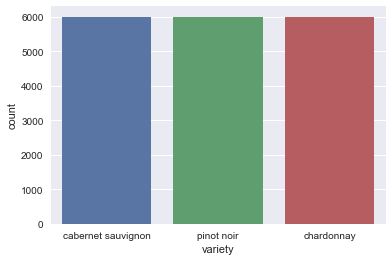

In [105]:
# Now let's take a another look at the data
sns.countplot(x='variety', data=test_df)
plt.show()

In order for the computer to understand what a "Pinot Noir" is, we need to translate it to numbers.

In [106]:
# Create a list of possible answers
varieties_list = list(test_df.variety.unique())
print(len(varieties_list))
# Create the key for the list
varieties_key = list(range(len(varieties_list)))

# Create the dictionary and insert the dictionary into our dataframe
variety_dict = dict(list(zip(varieties_list, varieties_key)))
inv_variety_dict = dict(list(zip(varieties_key, varieties_list)))
test_df['variety'] = test_df['variety'].replace(variety_dict)

# Print out the dictionary so we can understand what the computer is thinking
print(variety_dict)

3
{'cabernet sauvignon': 0, 'pinot noir': 1, 'chardonnay': 2}


Now, let's prep the descriptions for analysis.

In [107]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

test_df['description_text'] = test_df['description_text'].apply(text_cleaner)
test_df.head(10)

,country,description_text,variety
0,us,"Tightly wound and a little muted, without much...",0
1,argentina,"Leathery, horsey aromas suggest rubber and ber...",0
2,us,Blended from various vineyards around the vall...,0
3,us,This wine is quite blue-fruited aromatically f...,0
4,us,"It's rich in blackberry jam, with heady notes ...",0
5,us,"This soft, round and juicy wine is ripe and fu...",0
6,us,The winery's larger-production blend of severa...,0
7,us,The first release for Tranche from Blue Mounta...,0
8,chile,"Spicy aromas of eucalyptus, juniper, asphalt, ...",0
9,us,"A very nice wine that shows the smooth, comple...",0


## Prepare for Testing


Now, let's create a function that will run all of the tests we need with the inputs of test, inputs (X,Y), and method.

In [108]:
#Create a testing function that will fit the test the data.
def testing_func(test, models, method):
    # This is a local list used to temporarily store scores
    scores=[]
    # This list serves the For loop below putting the variables in   
    for x in models:
        #Fitting to Training Data
        test.fit(x[0], x[1])
        #Training Data Score
        scores.append(test.score(x[0], x[1]))
        #Test Data Score
        scores.append(test.score(x[2], x[3]))
        #CV Score
        scores.append(np.mean(cross_val_score(test, x[0], x[1], cv=5)))
    
    # Create a local dataframe to display our results cleanly
    local_results_df=pd.DataFrame(scores, columns=['Accuracy'], index=[method])
    print(local_results_df)
 

## TF_IDF
First, we use TF_IDF to vectorize the descriptions.

In [109]:
X = test_df['description_text']
y = test_df['variety']
#Applying the vectorizer
vect2 = TfidfVectorizer(min_df=20, analyzer = 'word', stop_words = 'english', ngram_range = (1,2))
X = vect2.fit_transform(X)
#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train2, y_test2= train_test_split(X, y, test_size=0.4, random_state=0)

y_train2 = y_train2.astype(int)
y_test2 = y_test2.astype(int)


Now let's use Latent Semantic Analysis to improve the model through dimension reduction. This applies Principle Components Analysis (PCA) to the vector matrix.

In [110]:
svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.fit_transform(X_test_tfidf)

In [111]:
# Go ahead and create our X variable for unsupervised learning
tfidf_X = test_df['description_text']

#Applying the vectorizer
vect2 = TfidfVectorizer(min_df=20, analyzer = 'word', stop_words = 'english', ngram_range = (1,2))
tfidf_X = vect2.fit_transform(tfidf_X)
#splitting into training and test sets
svd= TruncatedSVD(60)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
lsa_X = lsa.fit_transform(tfidf_X)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

In [112]:
# Our X,Y for the models
models = [[X_train_tfidf, y_train2, X_test_tfidf, y_test2], [X_train_lsa, y_train2, X_test_lsa, y_test2]] 

# TF_IDF is the method
tf_idf_method = ['TF-IDF Training', 'TF-IDF Test', 'TF-IDF Cross Validation', 
                 'TF-IDF with LSA Training', 'TF-IDF with LSA Test', 'TF-IDF with LSA Cross Validation']



This is a multinomial classification, so not all statistical methods can handle classifications that are not binary. Of the ones that can, this project will use the following: <br>
Logistic Regression <br>
SVC <br>
Random Forest

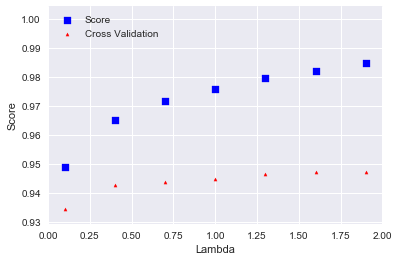

In [113]:
# Try to figure out the best Lambda for Logistic Regression by running the test with the PCA X variable and mapping them out.
# Temporary lists to store the results
yl = []
cl = []

# For loop to run the model with different Lambdas represented as L
numb = np.arange(0.1, 2.0, 0.3)
for l in numb:
    lr = LogisticRegression(C=l, multi_class='multinomial', solver='lbfgs')
    lr.fit(X_train_tfidf, y_train2)
    yl.append(lr.score(X_train_tfidf, y_train2))
    cl.append(np.mean(cross_val_score(lr, X_train_tfidf, y_train2, cv=5)))

# Plot the results of the accuracy and Cross Validation Score
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.xlabel('Lambda')
plt.ylabel('Score')
ax1.scatter(x=numb, y=yl, c='b', marker="s", label='Score')
ax1.scatter(x=numb, y=cl, s=10, c='r', marker="^", label='Cross Validation')
plt.legend(loc='upper left');
plt.show()

In [114]:
start = datetime.now()
lr = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs')
testing_func(lr, models, tf_idf_method)
print('It took the following time to complete this task:', datetime.now() - start)

                                  Accuracy
TF-IDF Training                   0.976019
TF-IDF Test                       0.951250
TF-IDF Cross Validation           0.944907
TF-IDF with LSA Training          0.929630
TF-IDF with LSA Test              0.849861
TF-IDF with LSA Cross Validation  0.924537
It took the following time to complete this task: 0:00:04.219755


In [115]:
# SKlearn has a tool that will optimize SVC
start = datetime.now()
svc = LinearSVC(multi_class='ovr')
# Set the hyperparameters
svcparameters = {'C':[1,5,8]}
# Run it through the tool.
grid = GridSearchCV(svc, svcparameters).fit(X_train_tfidf, y_train2)
predicted = grid.predict(X_test_tfidf)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
svcparameters = grid.best_params_

print('It took the following time to complete this task:', datetime.now() - start)

The best parameters are {'C': 1} with a score of %0.9434259259259259
It took the following time to complete this task: 0:00:01.081822


In [116]:
start = datetime.now()
svc = LinearSVC(C=svcparameters['C'], multi_class='ovr')
testing_func(svc, models, tf_idf_method)
print('It took the following time to complete this task:', datetime.now() - start)

                                  Accuracy
TF-IDF Training                   0.994259
TF-IDF Test                       0.950694
TF-IDF Cross Validation           0.943055
TF-IDF with LSA Training          0.929722
TF-IDF with LSA Test              0.844028
TF-IDF with LSA Cross Validation  0.923889
It took the following time to complete this task: 0:00:02.044581


In [117]:
start = datetime.now()
rfc = RandomForestClassifier(n_estimators=1000, 
                                 max_depth=16, n_jobs=4)
testing_func(rfc, models, tf_idf_method)
print('It took the following time to complete this task:', datetime.now() - start)

                                  Accuracy
TF-IDF Training                   0.959444
TF-IDF Test                       0.928333
TF-IDF Cross Validation           0.926574
TF-IDF with LSA Training          0.999815
TF-IDF with LSA Test              0.858056
TF-IDF with LSA Cross Validation  0.930370
It took the following time to complete this task: 0:03:10.965560


## SpaCy
Now, let's prep the data for analysis using SpaCy

In [118]:
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]

def bow_features(sentences, common_words):

    # Scaffold the data frame and initialize counts to zero.
    s_index = len(sentences)
    df = pd.DataFrame(columns=common_words, index=range(s_index))
    
    df['description_text'] = sentences['description_text']
    df['variety'] = sentences['variety']
    df = df.fillna(0)
    

    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['description_text']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
       
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1

        # This counter is just to make sure the kernel didn't hang.
        if i % 5000 == 0:
            print("Processing row {}".format(i))
            
    return df


In [119]:
start = datetime.now()
# Set up SpaCy
nlp = spacy.load('en')
# Create a dataframe for our parsed descriptions and parse them.
parsed_wine = test_df
parsed_wine['description_text'] = parsed_wine['description_text'].apply(lambda x: nlp(x))

# Figure out the most common words
description_words = parsed_wine['description_text'].apply(bag_of_words)
flat_list = [item for sublist in description_words for item in sublist]
common_words = set(flat_list)

# Use the second function to count the appearance of the common words in each description
word_counts = bow_features(parsed_wine, common_words)
print(word_counts.head(10))
print('It took the following time to complete this task:', datetime.now() - start)

Processing row 0
Processing row 5000
Processing row 10000
Processing row 15000
   clumsy  cranky  macul  monsanto  marry  unevolved  listen  butterscotchy  \
0       0       0      0         0      0          0       0              0   
1       0       0      0         0      0          0       0              0   
2       0       0      0         0      0          0       0              0   
3       0       0      0         0      0          0       0              0   
4       0       0      0         0      0          0       0              0   
5       0       0      0         0      0          0       0              0   
6       0       0      0         0      0          0       0              0   
7       0       0      0         0      0          0       0              0   
8       0       0      0         0      0          0       0              0   
9       0       0      0         0      0          0       0              0   

   mother  esperanza                        ...    

Now that there are word counts for each description, let's use that to see if the computer can figure out what the  variety is by the descriptions.

In [120]:
countries = pd.get_dummies(test_df, columns=['country'])
print(countries.shape, word_counts.shape)
word_counts = pd.merge(word_counts, countries)
print(word_counts.shape)
print(word_counts.head(10))
# Set the X,Y and create a training/test set.
X = word_counts.drop(['variety', 'description_text'], 1)
y = word_counts['variety']

# Splitting into training and test sets
Spacy_X_train, Spacy_X_test, Spacy_y_train, Spacy_y_test= train_test_split(X, y, test_size=0.4, random_state=0)
print(set(Spacy_y_test), varieties_list)
# These will be the models for SpaCy
models = [[Spacy_X_train, Spacy_y_train, Spacy_X_test, Spacy_y_test]] 

# Let's tell it that it is SpaCy
Spacy_method = ['SpaCy Training', 'SpaCy Test', 'SpaCy CV']

(18000, 30) (18000, 10475)
(17753, 10503)
   clumsy  cranky  macul  monsanto  marry  unevolved  listen  butterscotchy  \
0       0       0      0         0      0          0       0              0   
1       0       0      0         0      0          0       0              0   
2       0       0      0         0      0          0       0              0   
3       0       0      0         0      0          0       0              0   
4       0       0      0         0      0          0       0              0   
5       0       0      0         0      0          0       0              0   
6       0       0      0         0      0          0       0              0   
7       0       0      0         0      0          0       0              0   
8       0       0      0         0      0          0       0              0   
9       0       0      0         0      0          0       0              0   

   mother  esperanza     ...      country_new zealand  country_portugal  \
0       0    

In [121]:
start = datetime.now()

# Putting it in multi-class and changing the solver allows it to handle multinomial classification
lr = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs')
testing_func(lr, models, Spacy_method)
print('It took the following time to complete this task:', datetime.now() - start)

                Accuracy
SpaCy Training  0.998310
SpaCy Test      0.949169
SpaCy CV        0.944513
It took the following time to complete this task: 1:21:16.984451


In [122]:
start = datetime.now()
# The "ovr" method allows SVC to do multinomial classification
svc = LinearSVC(C=svcparameters['C'], multi_class='ovr')
testing_func(svc, models, Spacy_method)
print('It took the following time to complete this task:', datetime.now() - start)

                Accuracy
SpaCy Training  0.999812
SpaCy Test      0.940017
SpaCy CV        0.936813
It took the following time to complete this task: 0:00:31.735493


In [123]:
start = datetime.now()
rfc = RandomForestClassifier(n_estimators=1000, 
                                 max_depth=16, n_jobs=4)
testing_func(rfc, models, Spacy_method)
print('It took the following time to complete this task:', datetime.now() - start)

                Accuracy
SpaCy Training  0.963196
SpaCy Test      0.936356
SpaCy CV        0.934467
It took the following time to complete this task: 0:25:09.916385


## Results

3 3


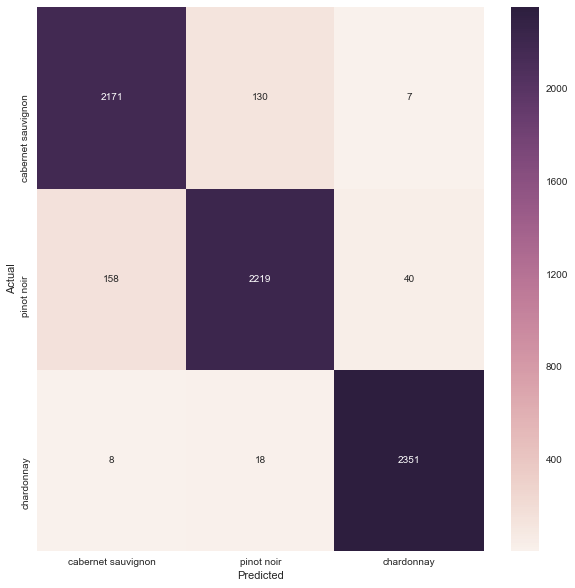

In [124]:
model = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs')
model.fit(Spacy_X_train, Spacy_y_train)
y_pred = model.predict(Spacy_X_test)
print(len(set(Spacy_y_test)), len(varieties_list))
conf_mat = confusion_matrix(Spacy_y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=varieties_list, yticklabels=varieties_list)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Clustering
Using the SpaCy generated dataframe, let's analyze the data set.

In [125]:
Spacy_X = word_counts.drop(['description_text'], 1)
pca = PCA(n_components=20)
Spacy_X_pca = pca.fit_transform(Spacy_X)
Spacy_X_pca = pd.DataFrame(Spacy_X_pca)

In [126]:
articles_by_component=pd.DataFrame(lsa_X,index=test_df['description_text']) 
articles_by_component.shape

print("Percent variance captured by all components:",total_variance*100)


for i in range(3): 
    print('Component {}:'.format(i)) 
    print(articles_by_component.loc[:,i].sort_values(ascending=False)[0:5])



Percent variance captured by all components: 13.9287625433
Component 0:
description_text
(This, wine, is, densely, packed, in, ripe, red, -, fruit, aromas, and, flavors, ,, but, still, expressive, in, earthy, notes, of, cocoa, nib, ,, anise, and, black, tea, ., Medium, tannins, and, plush, berry, flavors, flesh, out, the, mouthfeel, ,, with, a, crushed, satin, texture, ., The, evolving, finish, seamlessly, transitions, between, ripe, ,, fleshy, fruit, flavors, to, cherry, skin, and, finally, lightly, charred, oak, and, woody, spice, ., Drink, now–2018, .)                                                                                                                                                                        0.675040
(This, Bordeaux, blend, brings, expressive, ,, dark, ,, tannic, ,, coffee, /, toasty, flavors, to, the, party, ., The, juice, is, dark, and, tangy, ,, tight, and, compact, ,, but, fully, ripe, and, balanced, nicely, against, the, tannins, and, natural, acidity, 

LSA analysis pulls up similarities in the different components. Component 0 seems to really home in on red fruits such as cherries and raspberries in the descriptions. Component 1 has different wine descriptions that go into the wine's acidity, meaning it was of mention. Component 2 goes into the "rich" wines that are creamy, fruity, or complex in character.

Now, let's look at sentence similarity.

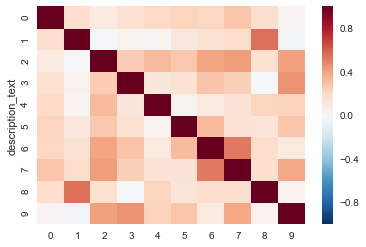

Key:
0 Tightly wound and a little muted, without much fruit on the nose or palate until the finish, which ends sweet. The Cab spent 26 months in barrel and is blended with 1% Petit Verdot.
1 Leathery, horsey aromas suggest rubber and berry scents. This feels alive and a bit edgy, with a mix of resiny oak, spice, red fruits and green herbs on the flavor profile. The finish is a touch abrasive, with a minty flavor.
2 Blended from various vineyards around the valley, this is a pretty, polished Cabernet for drinking now. Dry and softly tannic, it has lush, appealing black currant, black cherry jam, herb tea and smoky cedar flavors. It's fancy and a good value.
3 This wine is quite blue-fruited aromatically for a Cabernet. This continues on the palate, with boysenberry flavors backed by lightly grainy tannins. It provides interest, but you'd never peg it for Cabernet Sauvignon.
4 It's rich in blackberry jam, with heady notes of cassis liqueur and sweet oak. At this price, it's a great every

In [127]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(lsa_X) * np.asmatrix(lsa_X).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=test_df['description_text']).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


The strongest similarities are between the second and third sentences, which both discuss a wine with "plum" and "herbal" aromas. Sentences 1 and 5 also show similarities in their mentions of black fruits. Other sentences just show light to moderate similarity.

Now, let's try to use clusters to see if we can draw any other insights from the data.

In [128]:
models = [Spacy_X_pca, lsa_X]
kclust = np.arange(2, 11, 2)
for k in kclust:
    # Calculate predicted values.
    kmeans = KMeans(n_clusters=k, random_state=0)
    for m in models:
        kmeans.fit(m)
        # Check the solution against the data.
        labelskm = kmeans.labels_
        print(k, metrics.silhouette_score(m, labelskm, metric='euclidean'))

2 0.129509697798
2 0.0452809356433
4 0.112871487369
4 0.0483723333269
6 0.107535448322
6 0.0547123994222
8 0.102024570922
8 0.0584170227164
10 0.0852019378316
10 0.0616680601614


In [129]:
# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(lsa_X)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labelsaf = af.labels_
print(metrics.silhouette_score(lsa_X, labelsaf, metric='euclidean'))

Done
0.0994589898013


Unfortunately, the algorithms were not able to produce good clusters from the data set with the highest rating coming from features generated by Principle Components Analysis with a silhouette score of 0.129. The closer the score is to zero, the more random the clusters are, so these are not very good clusters.

While the data is not binary per se, most wine descriptions do not have multiple occurrences of words other than colors making the data have binary qualities to it. PCA/LSA both help to solve that through creating features that are not binary in nature, but these new features still underperform. Increasing the rows of data used in the analysis might help, but the machine I'm working on can't handle any more than what I already have without the kernel dying.